# Automated Annotation Workflow

This workflow uses the auto_annot tools from besca to newly annotate a scRNAseq dataset based on one or more preannotated datasets. Ideally, these datasets come from a similar tissue and condition.

We use supervised machine learning methods to annotate each individual cell utilizing methods like support vector machines (SVM) or logistic regression.

First, the traning dataset(s) and the testing dataset are loaded from h5ad files or made available as adata objects. Next, the training and testing datasets are corrected using scanorama, and the training datasets are then merged into one anndata object. Then, the classifier is trained utilizing the merged training data. Finally, the classifier is applied to the testing dataset to predict the cell types. If the testing dataset is already annotated (to test the algorithm), a report including confusion matrices can be generated.

In [1]:
import besca as bc

## Parameter specification

Give your analysis a name.

In [2]:
analysis_name = 'auto_annot_tutorial' # The analysis name will be used to name the output files

Specify column name of celltype annotation you want to train on.

In [3]:
celltype ='celltype' # This needs to be a column in the .obs of the training datasets (and test dataset if you want to generate a report)

Choose a method:

- linear: Support Vector Machine with Linear Kernel
- sgd: Support Vector Machine with Linear Kernel using Stochastic Gradient Descent
- rbf: Support Vector Machine with radial basis function kernel. Very time intensive, use only on small datasets.
- logistic_regression: Standard logistic classifier iwth multinomial loss.
- logistic_regression_ovr: Logistic Regression with one versus rest classification.
- logistic_regression_elastic: Logistic Regression with elastic loss, cross validates among multiple l1 ratios.

In [4]:
method = 'logistic_regression'

Specify merge method. Needs to be either scanorama or naive.

In [5]:
merge = 'scanorama' # We recommend to use scanorama here

Decide if you want to use the raw format or highly variable genes. Raw increases computational time and does not necessarily improve predictions.

In [6]:
use_raw = False # We recommend to use False here

You can choose to only consider a subset of genes from a signature set or use all genes.

In [7]:
genes_to_use = 'all' # We suggest to use all here, but the runtime is strongly improved if you select an appropriate gene set

## Data loading

### Read in all training sets and the testing set.

We will use a publicly available PBMC dataset, including ~3000 cells, as testing dataset. For the training dataset we use another PBMC dataset that is delivered with besca.

In [8]:
adata_test = bc.datasets.pbmc3k_processed() # Dataset to be annotated (it's already annotated in this case for testing)
adata_test_orig = adata_test.copy() # Make a copy of the testing data, which will be annotated in .obs, but not further modified
adata_train_list = [bc.datasets.pbmc_storage_processed()] # List of annotated training datasets

You can also load your own dataset from the file system. Specify folders where .h5ad files are found and their names. The datasets that are already annotated and should be used for training. If you only use one dataset please use list of one.

In [9]:
#test_dataset_path = '/path/to/test/dataset/folder'
#test_dataset = 'testdataset.h5ad'
#
#train_dataset_paths = ['/path/to/train/dataset/folder1', '/path/to/train/dataset/folder2']
#train_datasets = ['traindataset1.h5ad', 'traindataset2.h5ad']

In [10]:
#adata_train_list, adata_test, adata_test_orig = bc.tl.auto_annot.read_data(train_paths = train_dataset_paths, train_datasets= train_datasets, test_path=  test_dataset_path, test_dataset= test_dataset, use_raw = use_raw)

The testing dataset is already annotated to demonstrate the methodology. Both datasets include the same cell types.

In [11]:
adata_test.obs.celltype.unique()

[CD8 T-cell, B-cell, CD4 T-cell, FCGR3A+ monocyte, CD14+ monocyte, NK cell, pDC]
Categories (7, object): [CD8 T-cell, B-cell, CD4 T-cell, FCGR3A+ monocyte, CD14+ monocyte, NK cell, pDC]

In [12]:
adata_train_list[0].obs.celltype.unique()

[CD8 T-cell, CD4 T-cell, B-cell, monocyte CD14+, NK cell, monocyte CD16+, unknown, dendritic cell]
Categories (8, object): [CD8 T-cell, CD4 T-cell, B-cell, monocyte CD14+, NK cell, monocyte CD16+, unknown, dendritic cell]

## Correct datasets (e.g. using scanorama) and merge training datasets

This function merges training datasets, removes unwanted genes, and if scanorama is used corrects for datasets.

In [13]:
adata_train, adata_test_corrected = bc.tl.auto_annot.merge_data(adata_train_list, adata_test, genes_to_use = genes_to_use, merge = merge)

merging with scanorama
using scanorama rn
Found 327 genes among all datasets
[[0.         0.98113208]
 [0.         0.        ]]
Processing datasets (0, 1)
integrating training set
calculating intersection


## Train the classifier

The returned scaler is fitted on the training dataset (to zero mean and scaled to unit variance). The scaling will then be applied to the counts in the testing dataset and then the classifier is applied to the scaled testing dataset (see next step, adata_predict()). This function will run multiple jobs in parallel if if logistic regression was specified as method.

In [14]:
classifier, scaler = bc.tl.auto_annot.fit(adata_train, method, celltype, njobs=10)

## Prediction

Use fitted model to predict celltypes in adata_pred (adata_test_corrected in our case).  In the case of logistic regression, the threshold specifies the probability that needs to be reached to annotate a cell type or will be annotated as "unknown" if not reached. The threshold should be set to 0 or left out for SVM.

In [15]:
adata_predicted = bc.tl.auto_annot.adata_predict(classifier = classifier, scaler = scaler, adata_pred = adata_test_corrected, adata_orig = adata_test_orig, threshold = 0.1)

The prediction was added in a new column called 'auto_annot'.

If in addition to the most likely class you would like to have all class probabilities returned use the following function. (This is only a sensible choice if using logistic regression.)

In [17]:
adata_predicted = bc.tl.auto_annot.adata_pred_prob(classifier = classifier, scaler = scaler, adata_pred = adata_test_corrected, adata_orig = adata_test_orig, threshold = 0.1)

## Output

The adata object that includes the predicted cell type annotation can be written out as h5ad file.

In [19]:
adata_predicted.write('/tmp/adata_predicted.h5ad')

If the testing dataset included already a cell type annotation, a report can be generated and written, which includes metrics,  confusion matrices and comparative umap plots.

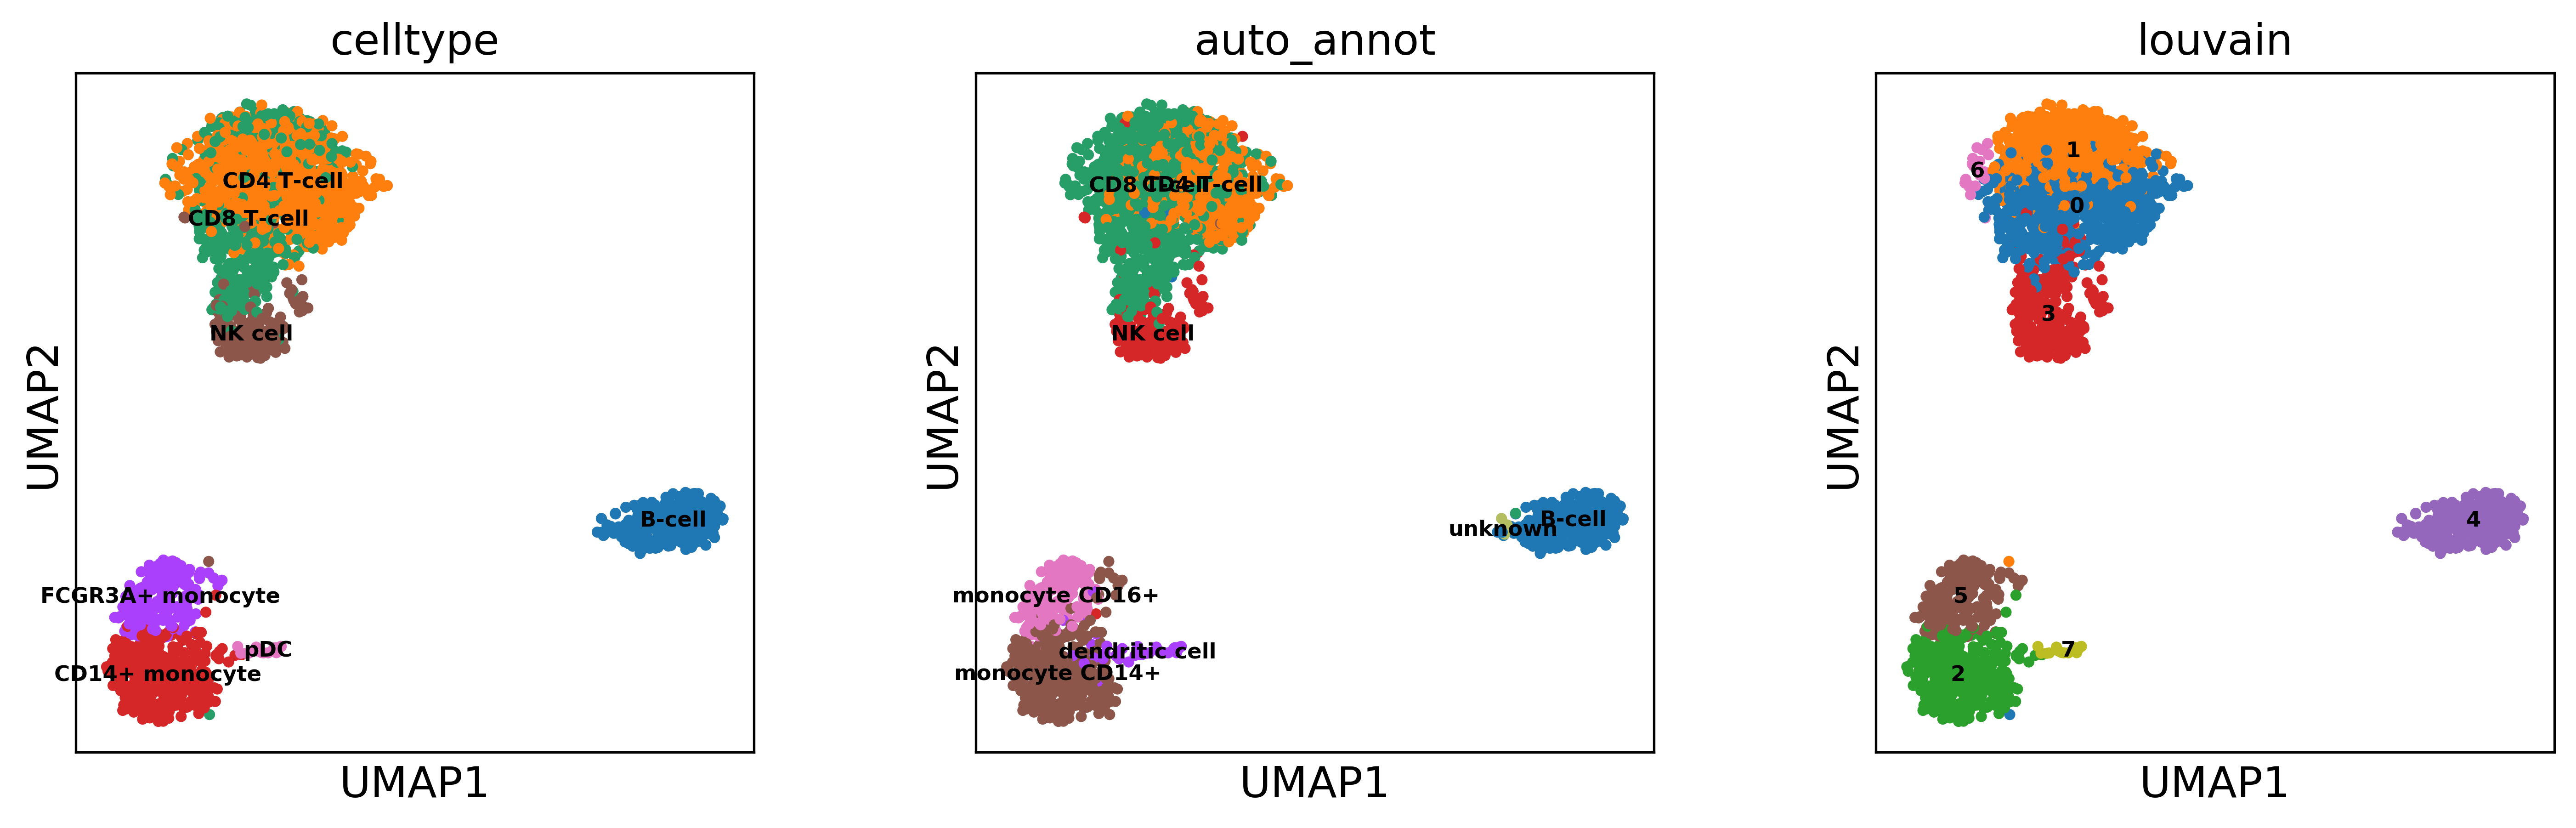

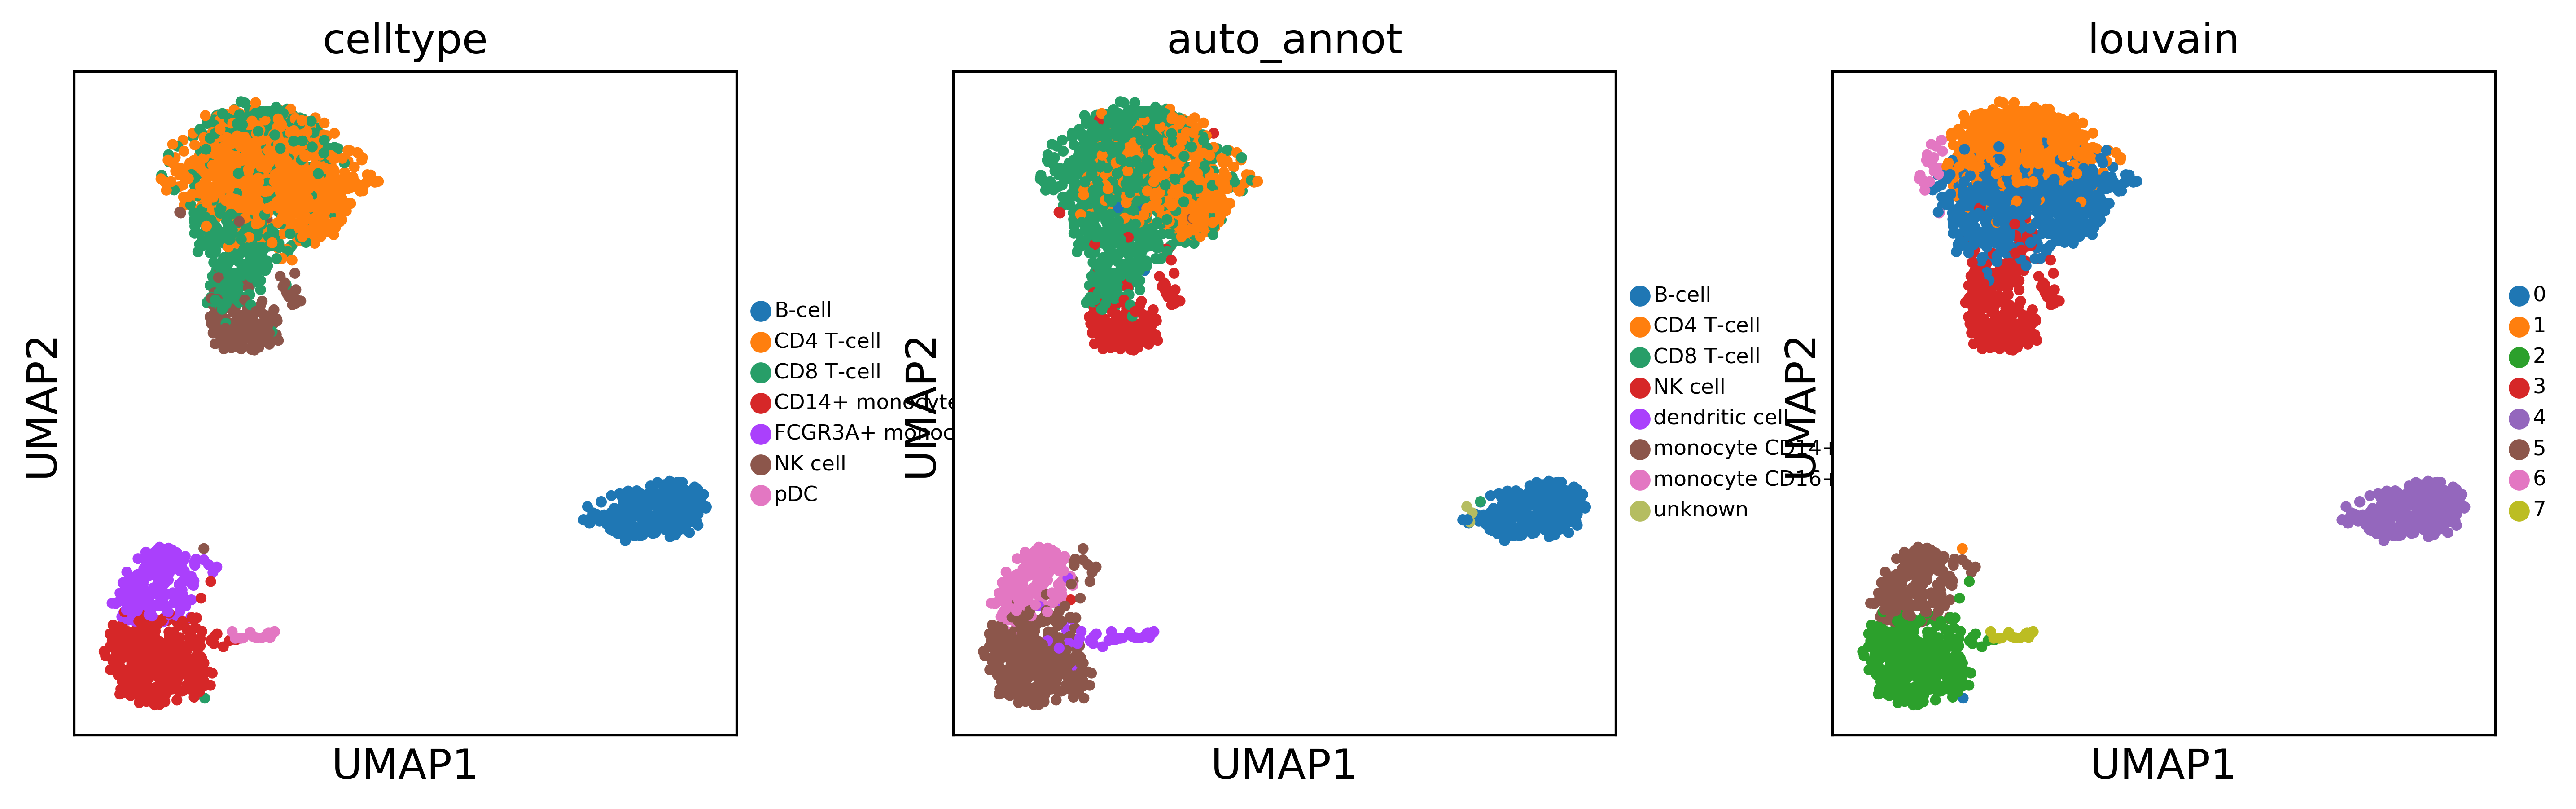

Confusion matrix, without normalization
Normalized confusion matrix


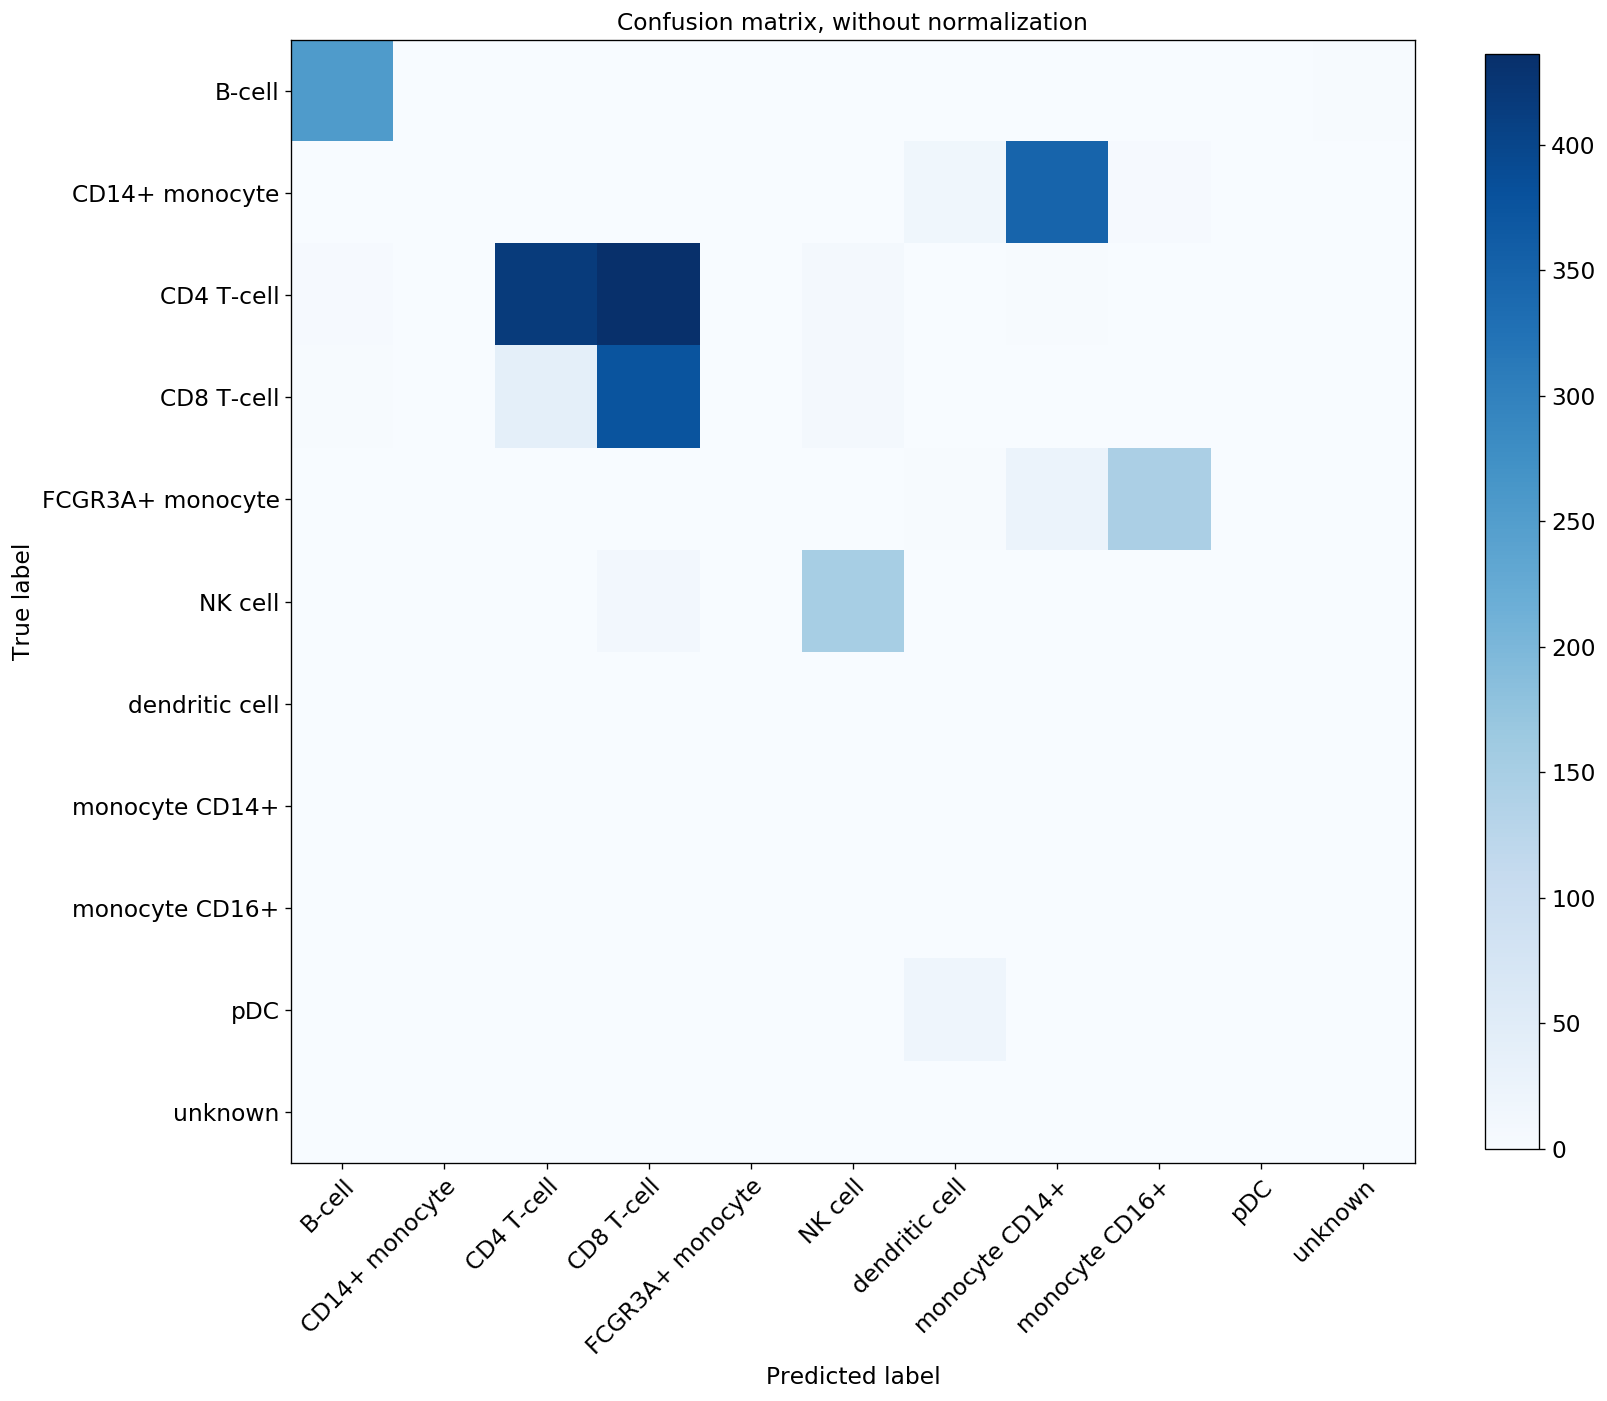

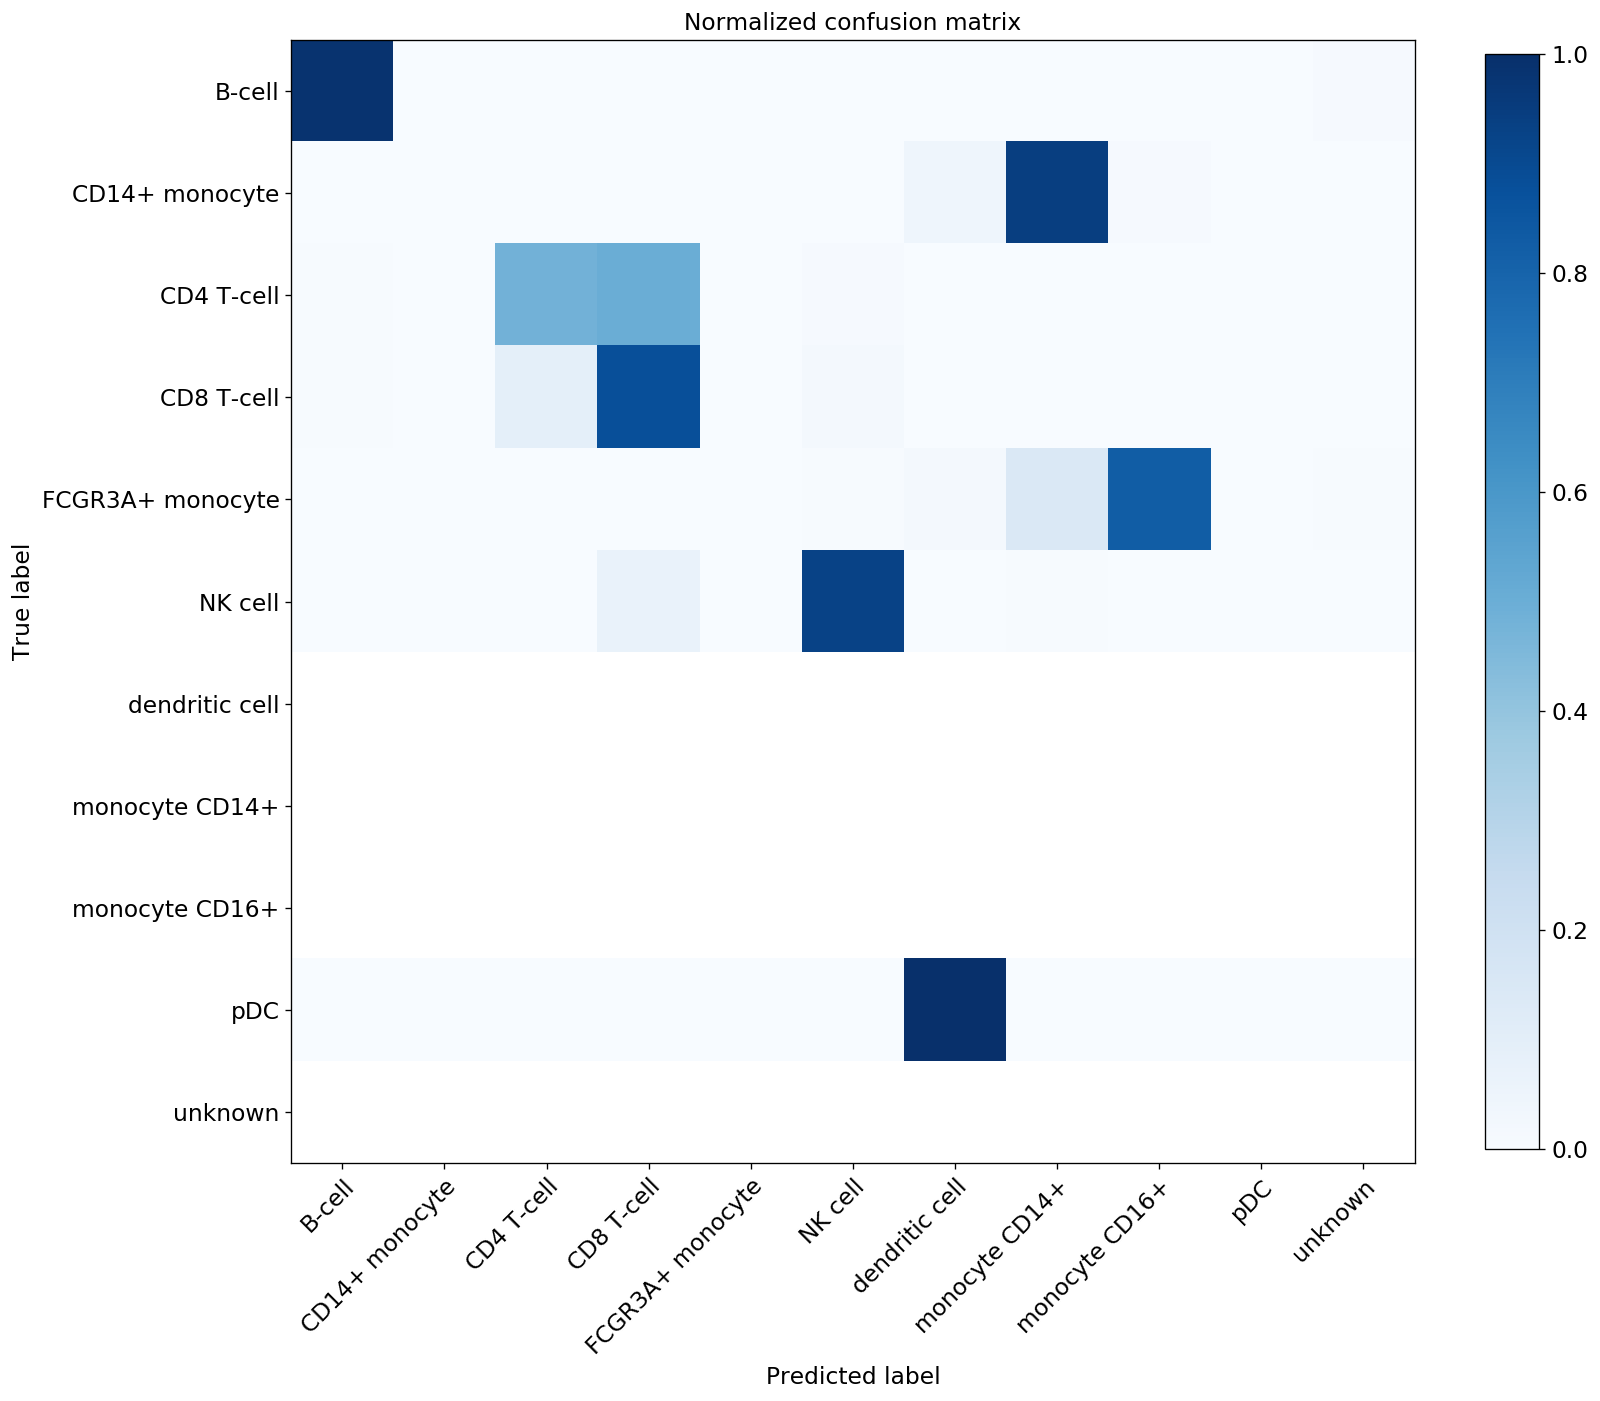

In [20]:
%matplotlib inline
sc.settings.set_figure_params(dpi=90)
bc.tl.auto_annot.report(adata_predicted, celltype, method, analysis_name, False, merge, use_raw, genes_to_use, clustering = 'louvain')

## let's try another classifier (SVM)

In [21]:
analysis_name = 'auto_annot_tutorial_svm' 
celltype ='celltype' #column name of celltype of interest
method = 'linear'  # rbf or linear or sgd, rbf extremely slow cannot recommend, logistic_regression recommended, as you can get probabilities, random_forest is a fast but not very powerful option (in current implementation)
merge = 'scanorama'
use_raw = False
genes_to_use = 'all'

In [22]:
adata_test = adata_test_orig.copy()

In [23]:
adata_train, adata_test_corrected = bc.tl.auto_annot.merge_data(adata_train_list, adata_test, genes_to_use = genes_to_use, merge = merge)

merging with scanorama
using scanorama rn
Found 327 genes among all datasets
[[0.   0.98]
 [0.   0.  ]]
Processing datasets (0, 1)
integrating training set
calculating intersection


In [24]:
classifier, scaler = bc.tl.auto_annot.fit(adata_train, method, celltype)

In [25]:
adata_predicted = bc.tl.auto_annot.adata_predict(classifier = classifier, scaler = scaler, adata_pred = adata_test_corrected, adata_orig = adata_test_orig)

In [27]:
adata_predicted.write('/tmp/adata_predicted_svm.h5ad')

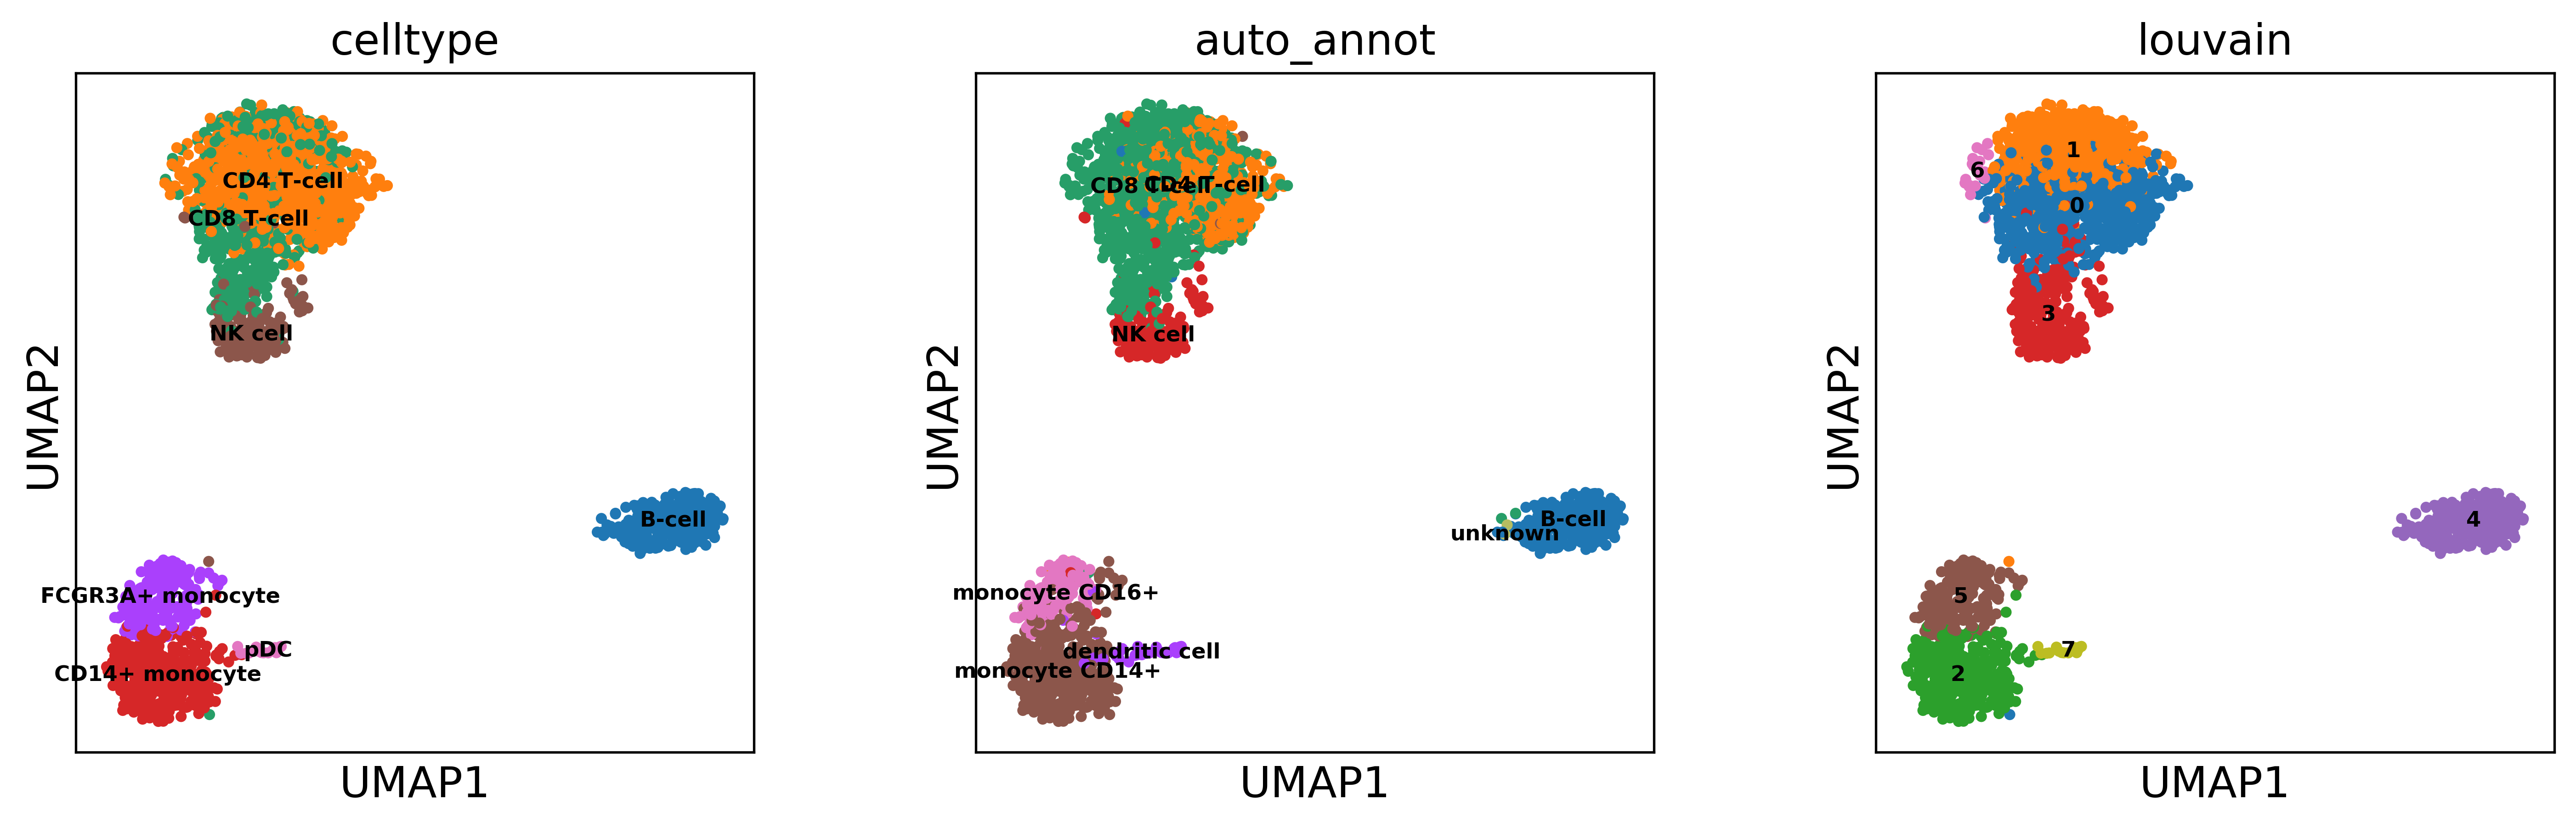

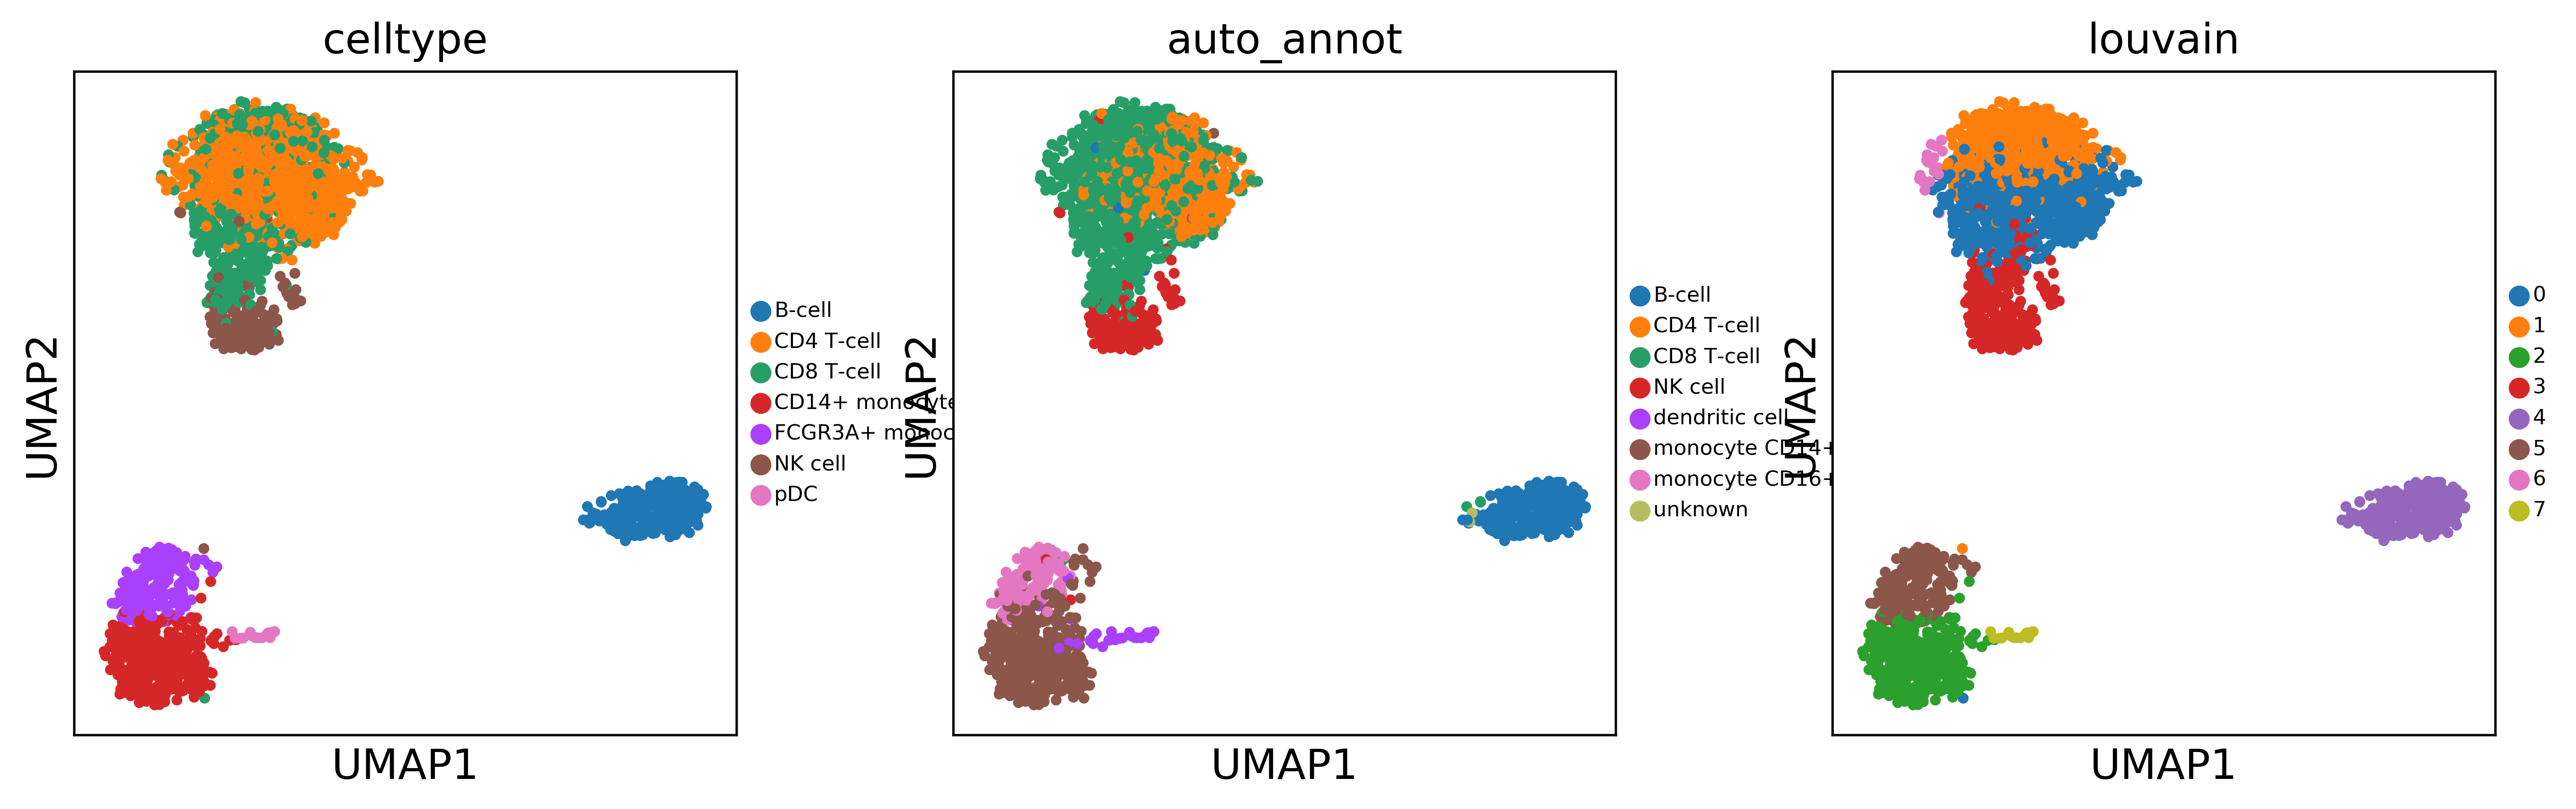

Confusion matrix, without normalization
Normalized confusion matrix


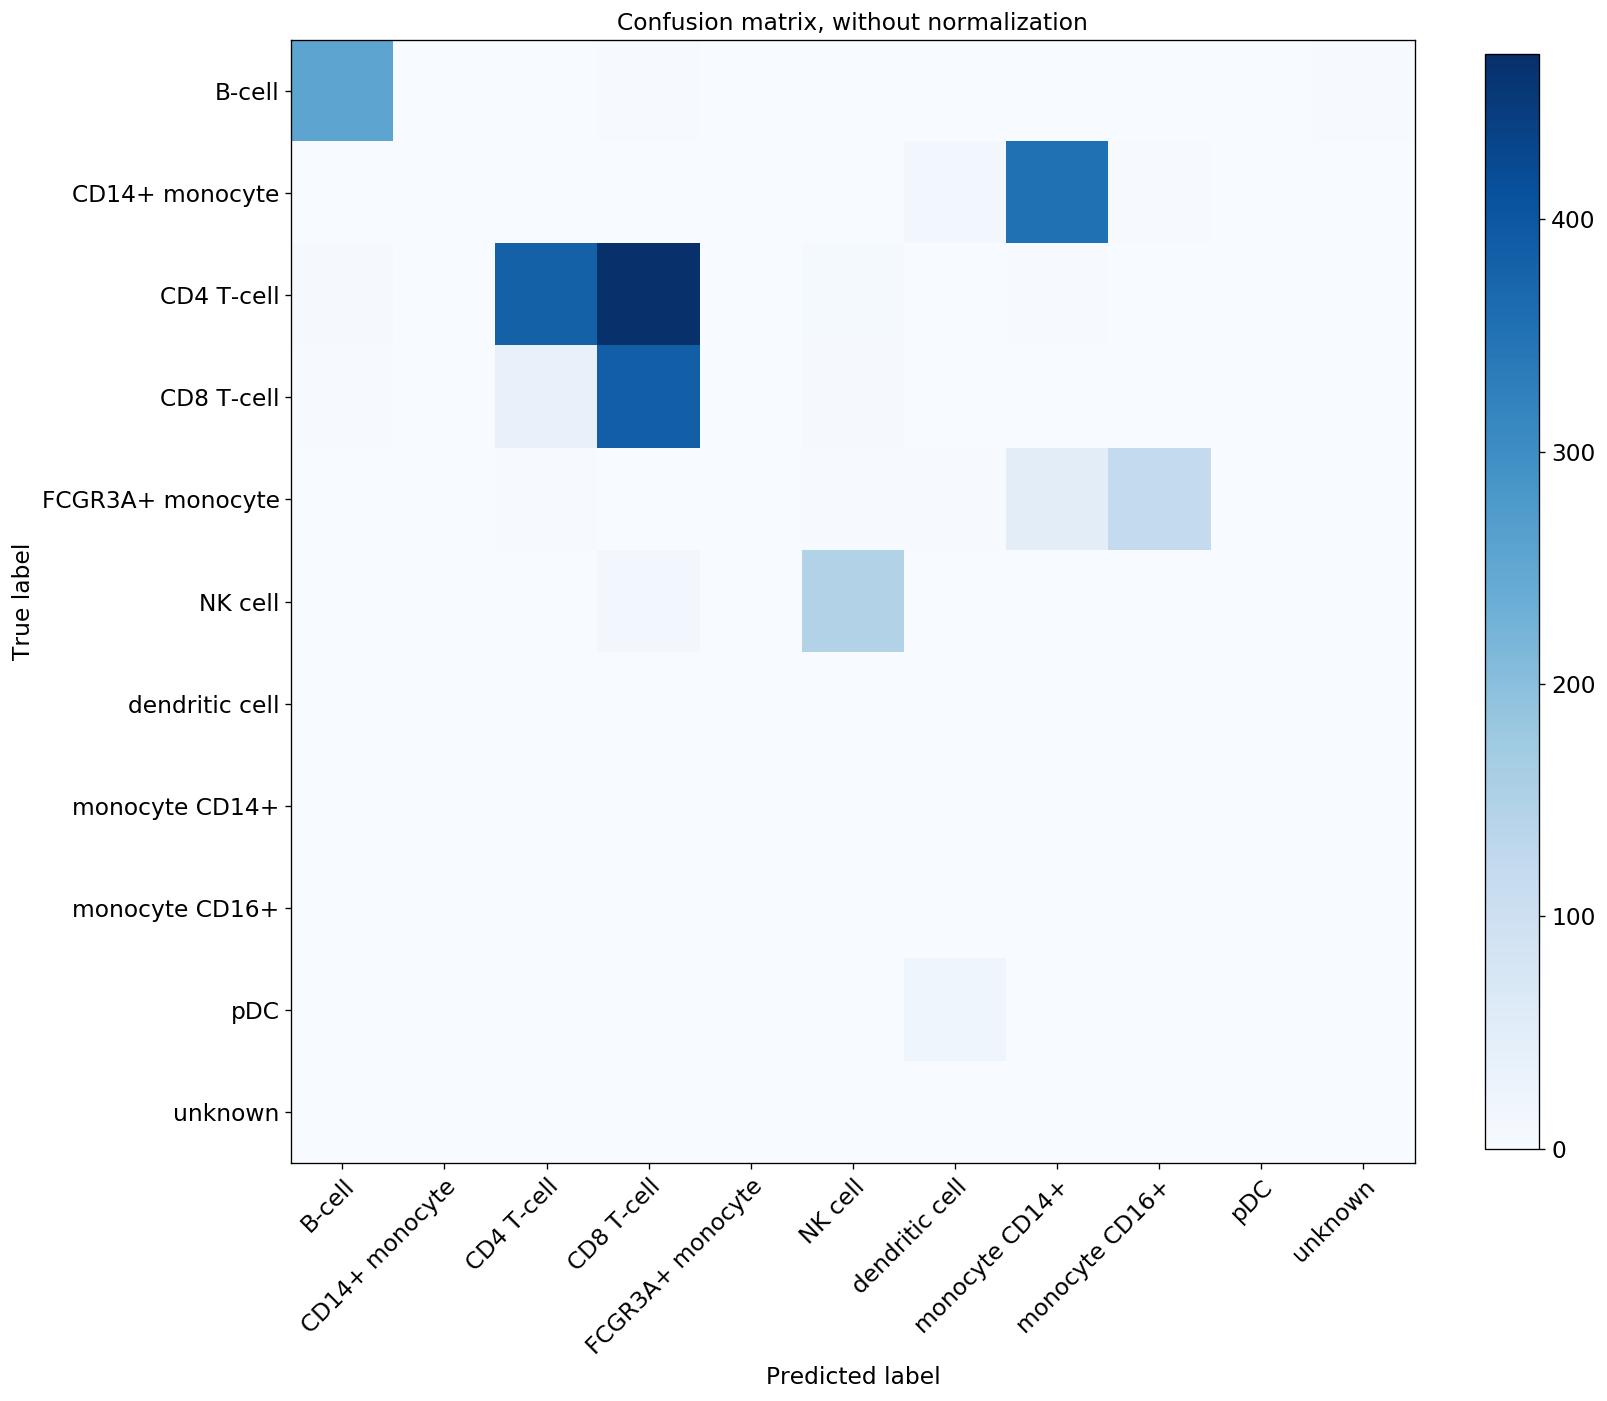

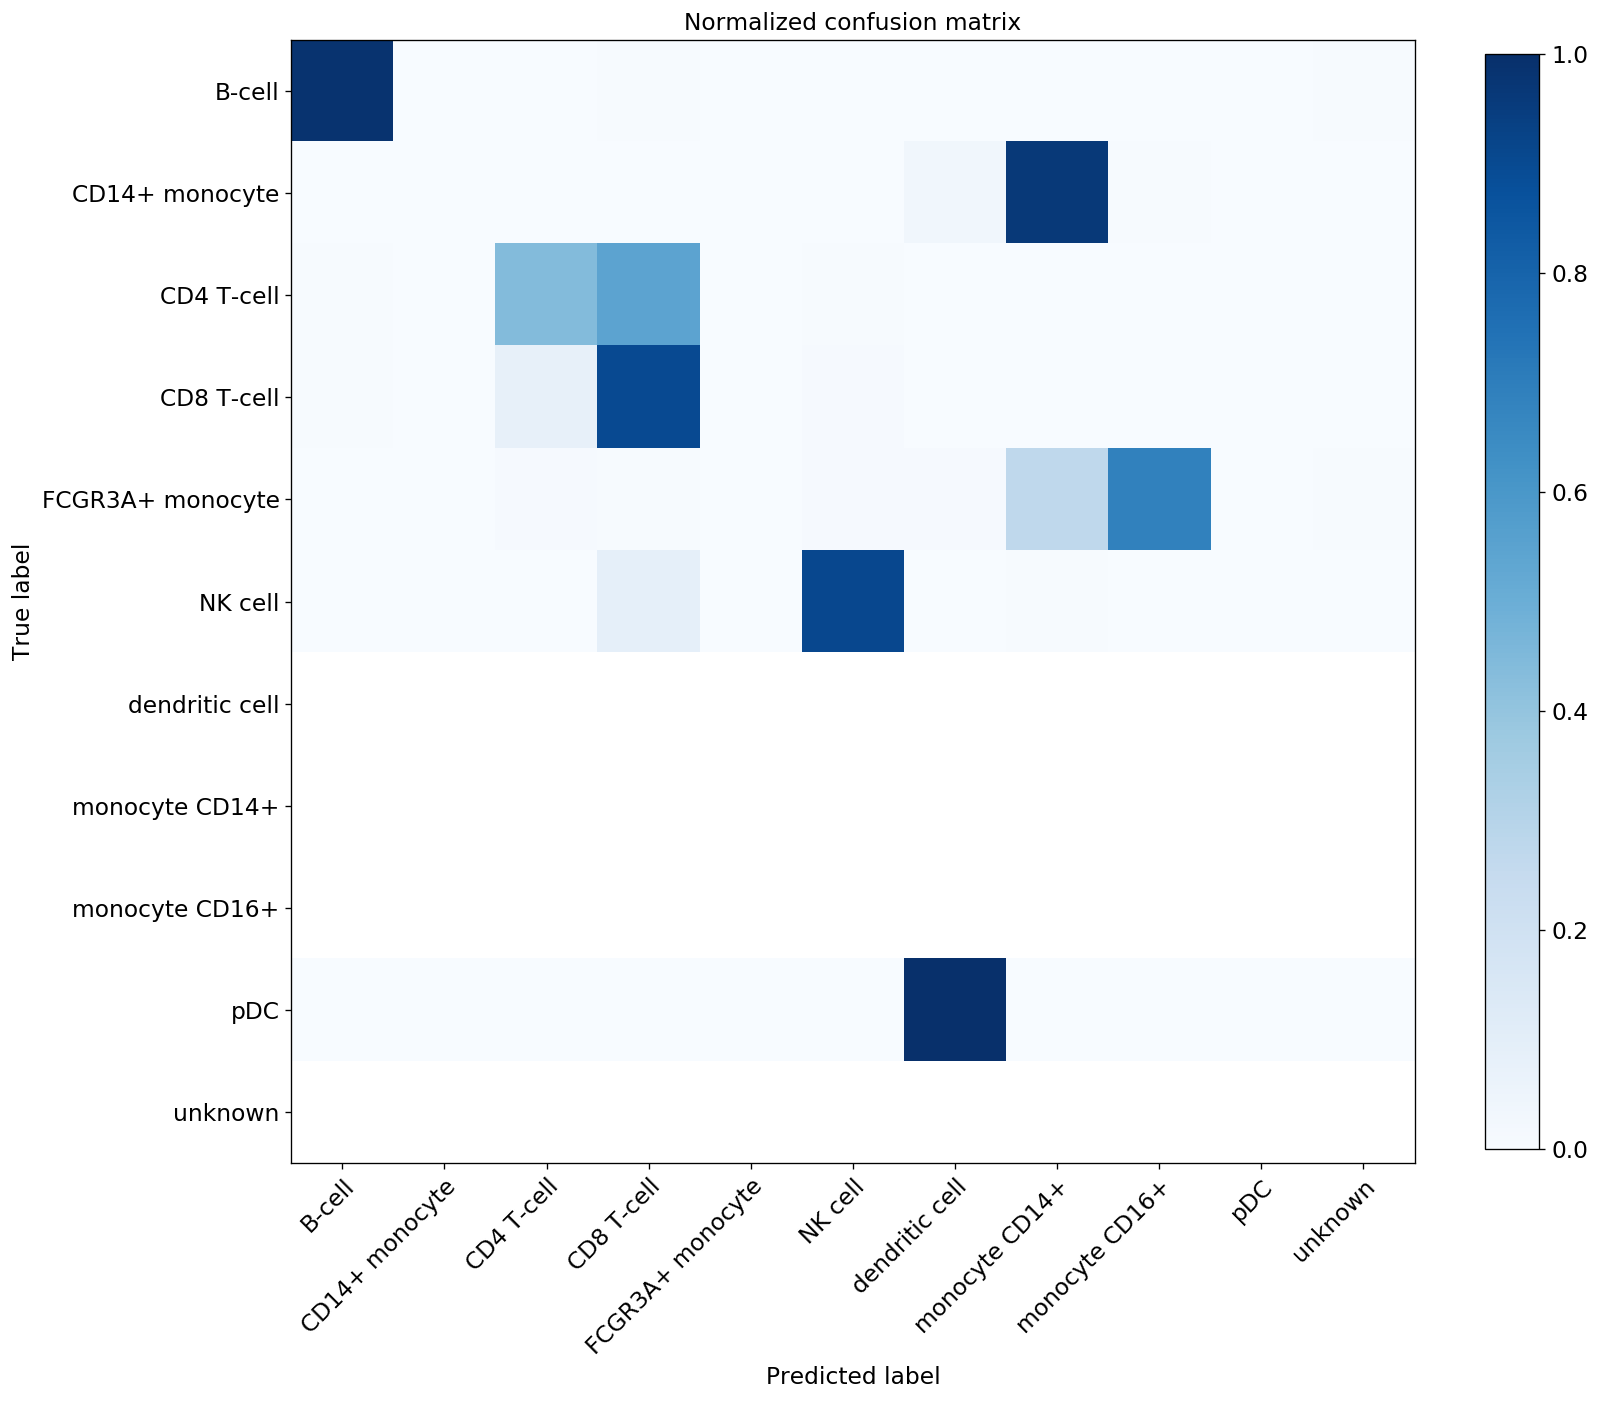

In [28]:
%matplotlib inline
sc.settings.set_figure_params(dpi=90)
bc.tl.auto_annot.report(adata_predicted, celltype, method, analysis_name, False, merge, use_raw, genes_to_use, clustering = 'louvain')

## let's try with a speciefied gene set

In [29]:
analysis_name = 'auto_annot_tutorial_geneset' 
celltype ='celltype' #column name of celltype of interest
method = 'linear'  # rbf or linear or sgd, rbf extremely slow cannot recommend, logistic_regression recommended, as you can get probabilities, random_forest is a fast but not very powerful option (in current implementation)
merge = 'scanorama'
use_raw = False


In [31]:
annotSigns = bc.datasets.load_immune_signatures()
allGenes = lambda annotSigns: [item for sublist in annotSigns for item in sublist]
genes_to_use = list(set(allGenes(list(annotSigns.values())))) 
display(genes_to_use[:10])

['SLC45A2',
 'MCM4',
 'PCNA',
 'LILRB2',
 'C3AR1',
 'ITGAX',
 'KLRC1',
 'LAMP1',
 'SIGLEC8',
 'CXXC5']

In [32]:
adata_test = adata_test_orig.copy()

In [33]:
adata_train, adata_test_corrected = bc.tl.auto_annot.merge_data(adata_train_list, adata_test, genes_to_use = genes_to_use, merge = merge)

merging with scanorama
using scanorama rn
Found 95 genes among all datasets
[[0.   0.99]
 [0.   0.  ]]
Processing datasets (0, 1)
integrating training set
calculating intersection


In [34]:
classifier, scaler = bc.tl.auto_annot.fit(adata_train, method, celltype)

In [35]:
adata_predicted = bc.tl.auto_annot.adata_predict(classifier = classifier, scaler = scaler, adata_pred = adata_test_corrected, adata_orig = adata_test_orig)

In [37]:
adata_predicted.write('/tmp/adata_predicted_svm.h5ad')

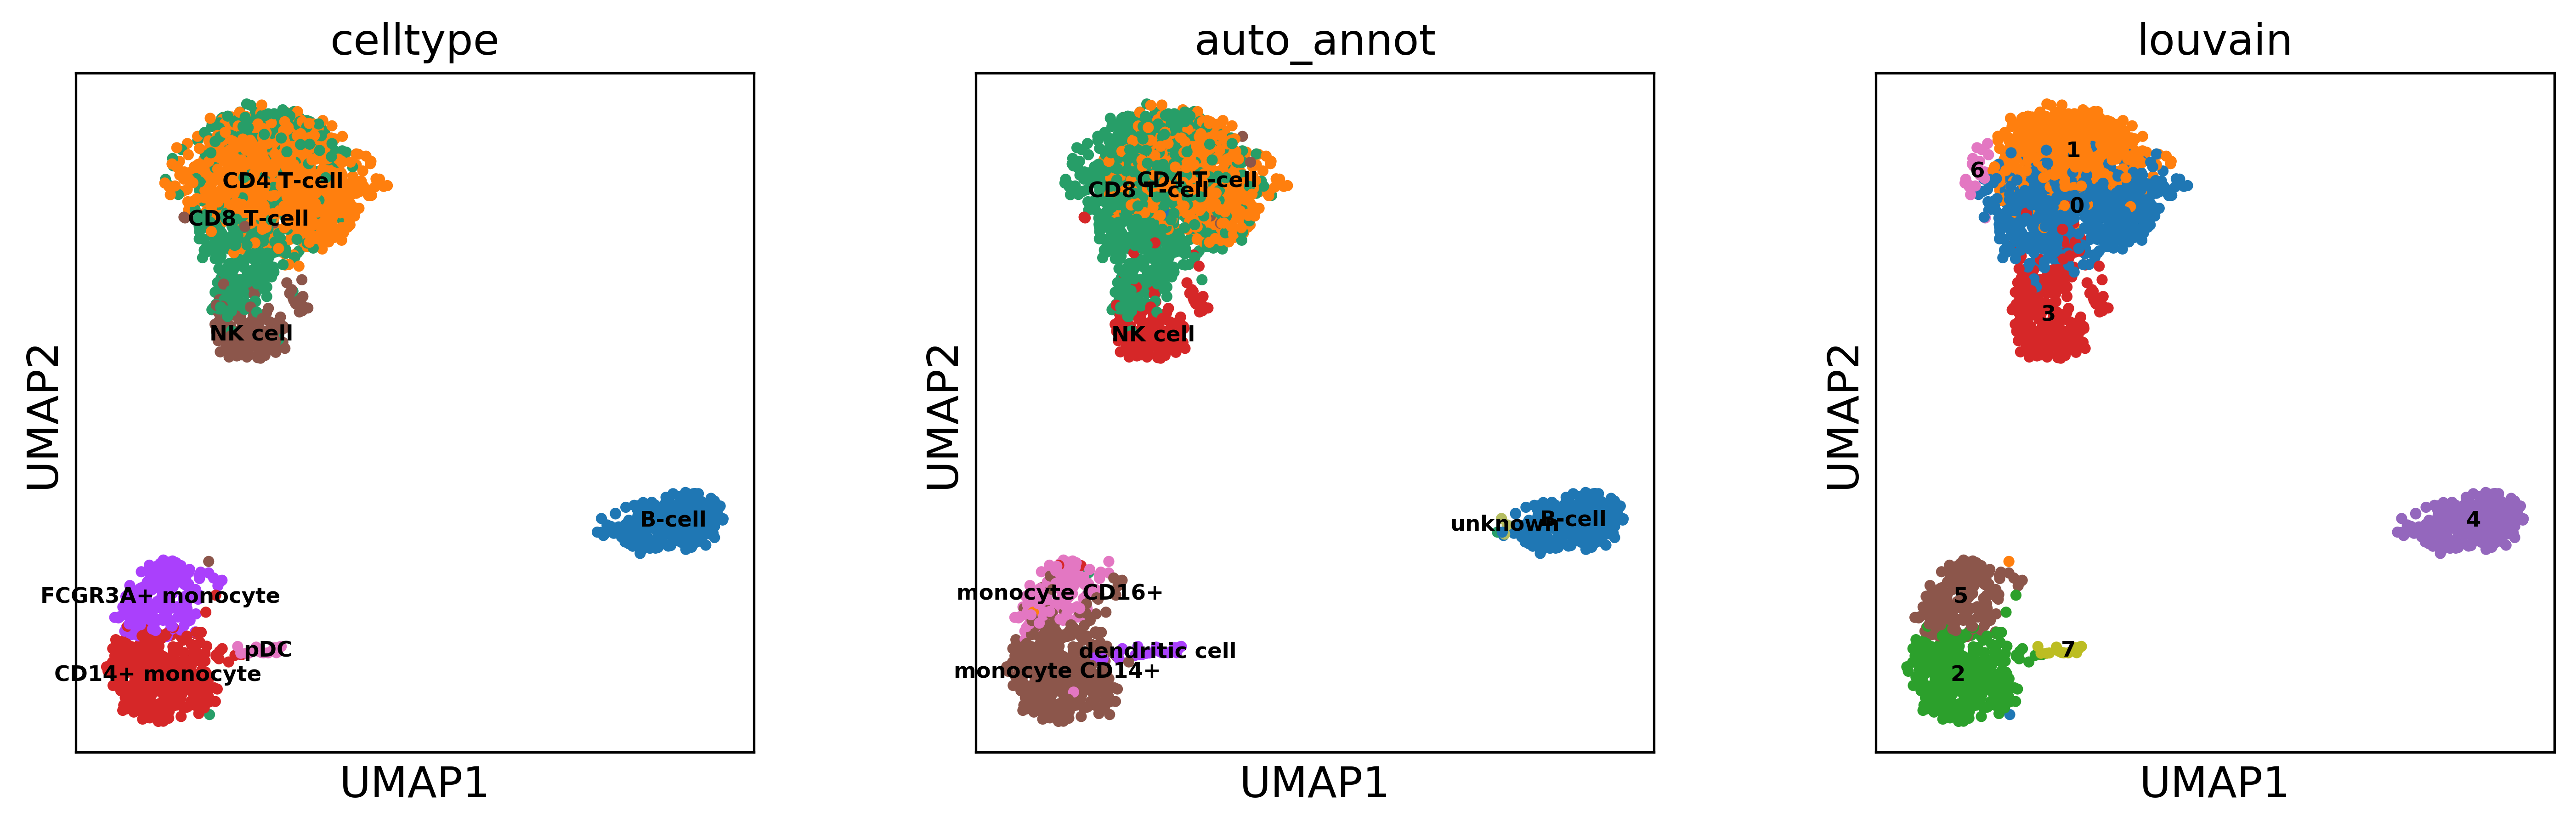

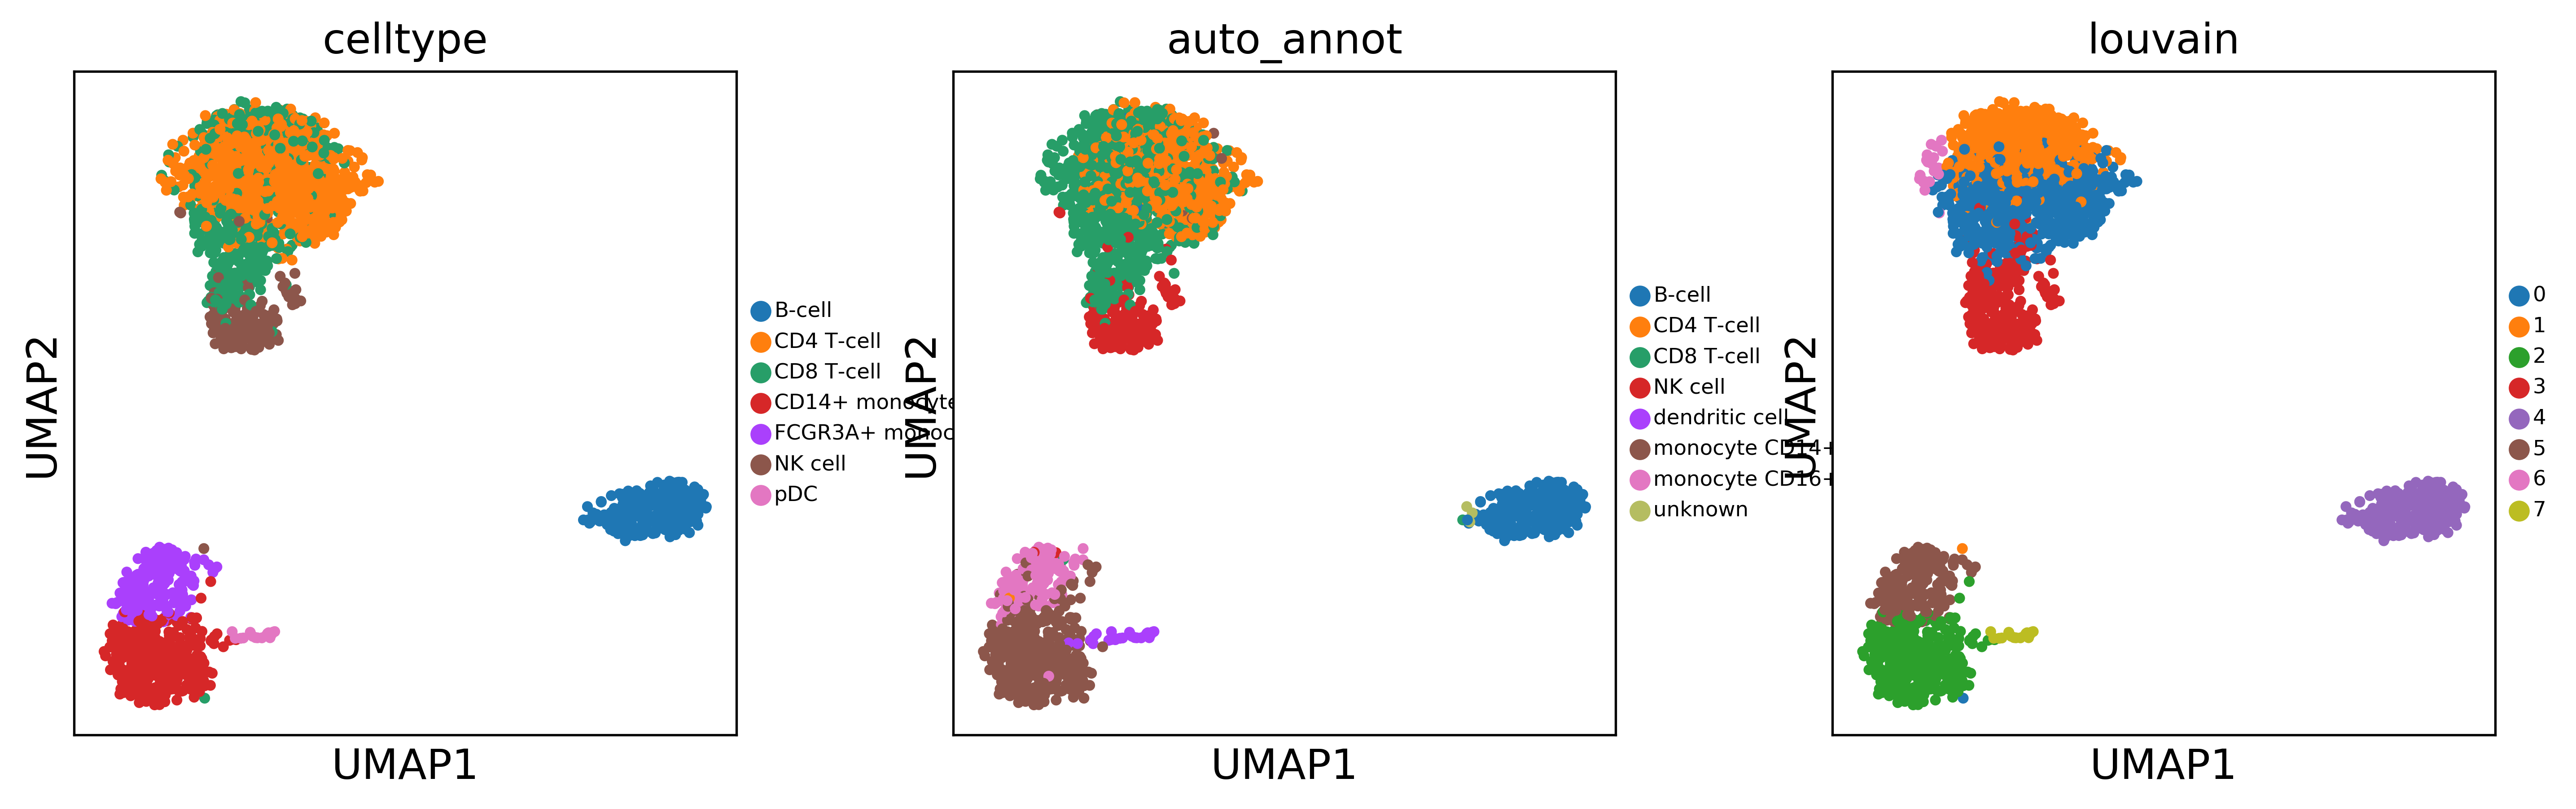

Confusion matrix, without normalization
Normalized confusion matrix


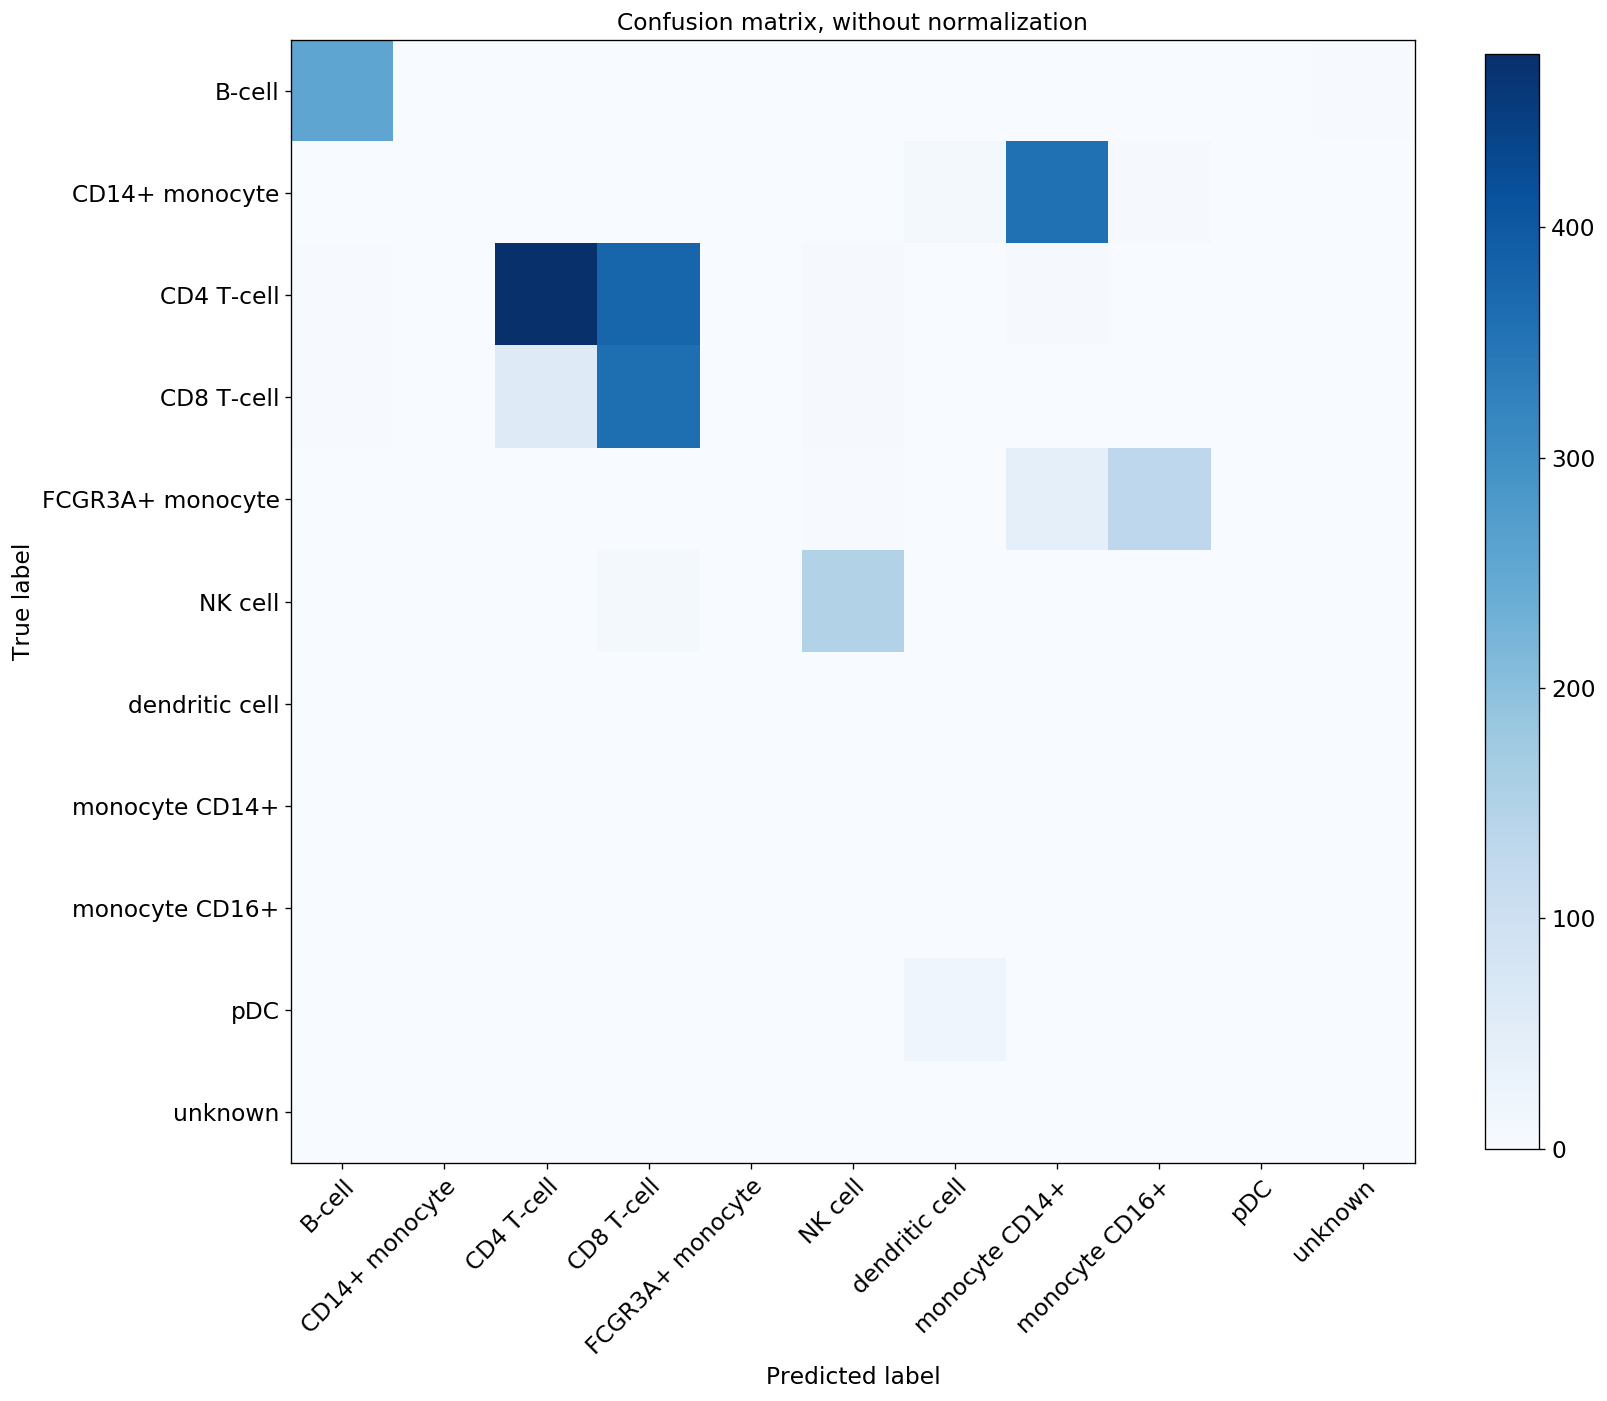

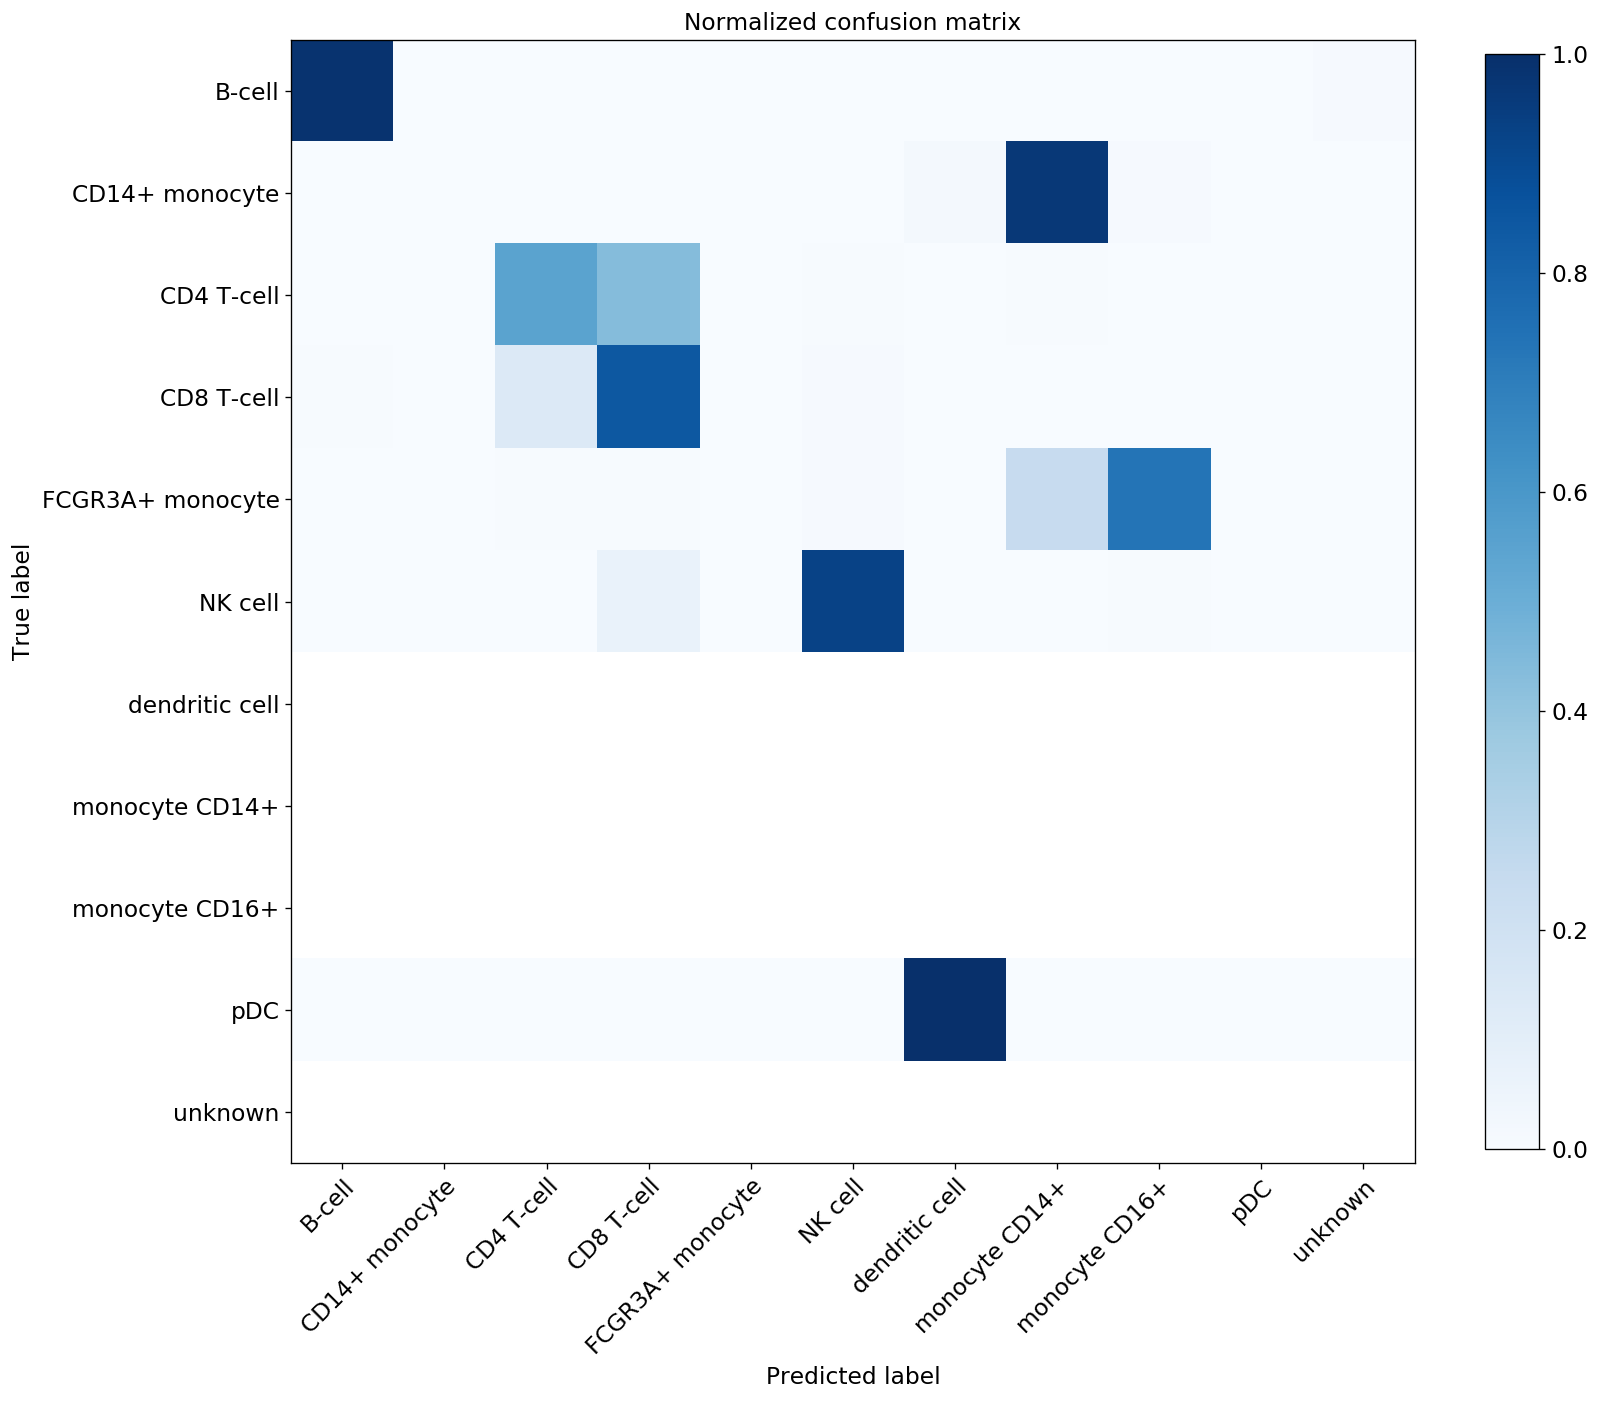

In [38]:
%matplotlib inline
sc.settings.set_figure_params(dpi=90)
bc.tl.auto_annot.report(adata_predicted, celltype, method, analysis_name, False, merge, use_raw, genes_to_use, clustering = 'louvain')